In [2]:
import pandas as pd
from scipy.stats import zscore

# Load the Excel file into a DataFrame
file_path = "/Users/marclambertes/Downloads/Men Database/Eredivisie 2024-2025.xlsx"
# league_name = file_path.split("/")[-1].split(".")[0]  # Extracting the title of the Excel file
df = pd.read_excel(file_path)

# Filter the DataFrame to only include rows where the 'position' column is 'GK'
df = df[df['Position'] == 'GK']
df.rename(columns={"Short / medium passes per 90": "Short - medium passes per 90"}, inplace=True)

# Drop rows with missing values
df.dropna(subset=['Passes per 90', 'Back passes per 90', 'Lateral passes per 90', 'Short - medium passes per 90'], inplace=True)

# Calculate the sum of "Back passes per 90" and "Lateral passes per 90"
back_lateral_passes = df["Back passes per 90"] + df["Lateral passes per 90"]

# Calculate the total passes per 90
total_passes_per_90 = df["Passes per 90"]

# Calculate the percentage of backward and lateral passes out of the total passes per 90
percentage_back_lateral = (back_lateral_passes / total_passes_per_90) * 100

# Calculate the sum of "Short - medium passes per 90"
short_medium_passes = df["Short - medium passes per 90"]

# Calculate the percentage of short to medium passes out of the total passes per 90
percentage_short_medium = (short_medium_passes / total_passes_per_90) * 100

# Create a new DataFrame with "Player", "Team within selected timeframe", "Percentage (Back-Lateral)", and "Percentage (Short-Medium)"
result_df = pd.DataFrame({
    "Player": df["Player"],
    "Team within selected timeframe": df["Team within selected timeframe"],
    "Passes per 90": df["Passes per 90"],
    "Percentage (Back-Lateral)": percentage_back_lateral,
    "Percentage (Short-Medium)": percentage_short_medium
})

# Calculate the z-scores for each metric
result_df['Passes per 90 Z-Score'] = zscore(result_df['Passes per 90'])
result_df['Percentage back-lateral Z-Score'] = zscore(result_df['Percentage (Back-Lateral)'])
result_df['Percentage short-medium Z-Score'] = zscore(result_df['Percentage (Short-Medium)'])

# Calculate the average z-score for each player
result_df['Average Z-Score'] = (result_df['Passes per 90 Z-Score'] + result_df['Percentage back-lateral Z-Score'] + result_df['Percentage short-medium Z-Score']) / 3

# Map the average z-scores to a score between 0 and 100
min_score = result_df['Average Z-Score'].min()
max_score = result_df['Average Z-Score'].max()
result_df['Score'] = ((result_df['Average Z-Score'] - min_score) / (max_score - min_score)) * 100

# result_df['League'] = league_name

# Display the resulting DataFrame
print(result_df[['Player', 'Team within selected timeframe', 'Score']])
result_df.to_excel("/Users/marclambertes/Downloads/GBI.xlsx", index=False)


               Player Team within selected timeframe       Score
17         W. Benítez                            PSV   73.346649
31   T. Wellenreuther                      Feyenoord   69.511589
55            N. Olij               Sparta Rotterdam   72.603720
57      L. Unnerstall                         Twente   58.209286
66          V. Barkas                        Utrecht   63.828006
94         E. Vaessen                      Groningen   43.099459
99     J. Schendelaar                     PEC Zwolle   68.953628
147         N. Bakker                    Almere City   33.992236
149        D. Bielica                      NAC Breda   54.627146
190          R. Roefs                            NEC   38.332368
192   M. Branderhorst                Fortuna Sittard    0.000000
208       L. Plogmann                Go Ahead Eagles   68.902985
211   M. van der Hart                     Heerenveen  100.000000
213     F. de Keijzer                       Heracles   15.585450
215  T. Didillon-Hödl    

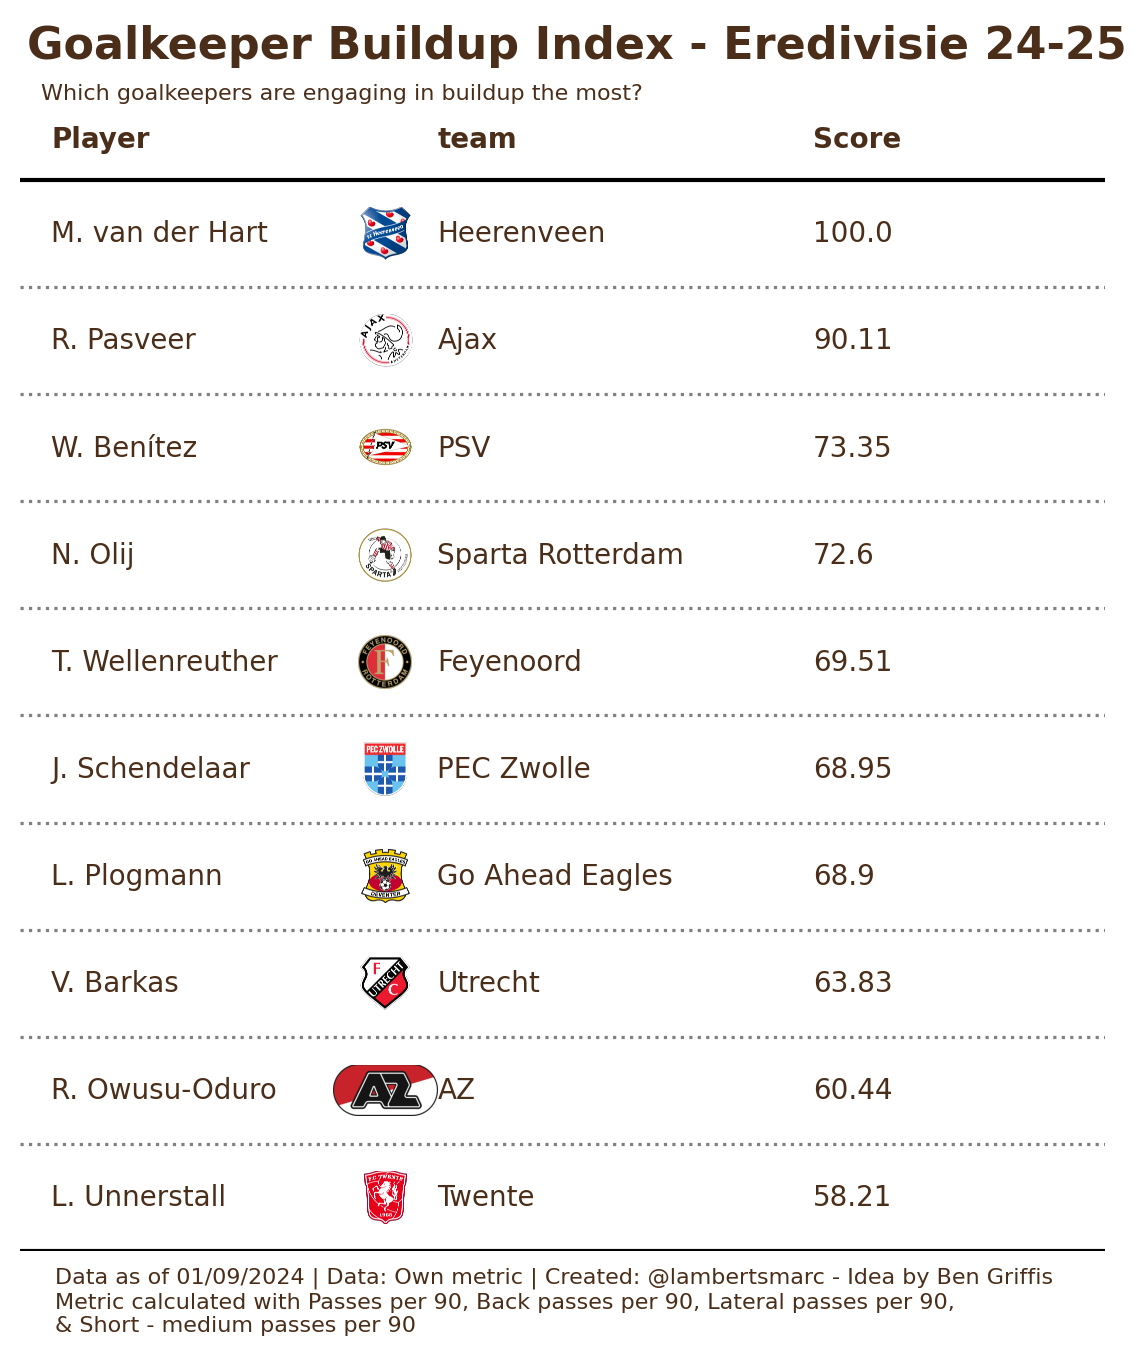

In [4]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter


df = pd.read_excel('/Users/marclambertes/Downloads/GBI.xlsx')
#df = df.rename(columns={'Normalized Harmonic Mean': 'Score'})
df = df.rename(columns={'Team within selected timeframe': 'team'})
df['Score'] = (df['Score']).round(2)
df = df.rename(columns={'playerName': 'Player'})
df = df.sort_values(by='Score', ascending=False).head(10)


def ax_logo(team, ax,):
    path = r'/Users/marclambertes/Downloads/Images'
    club_icon = Image.open('%s/%s.png' %(path,team))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

indexdf = df.head(10)[['Player', 'team', 'Score']].reset_index(drop=True)
indexdf_short=indexdf[::-1]


fig = plt.figure(figsize=(7,8), dpi=200)
ax = plt.subplot()

ncols = len(indexdf_short.columns.tolist())+1
nrows = indexdf_short.shape[0]

ax.set_xlim(0, ncols + 1.2)
ax.set_ylim(0, nrows + 1.5)

# lgs = ['J1', 'J2', 'Ekstraklasa', 'J3']
# if lg in lgs:
positions = [0.15, 2.0, 3.8, 5.7]
# else:
#     positions = [0.25, 2.25, 3.75, 4.5, 5.25]
columns = indexdf_short.columns.tolist()

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if 'xG per 90' in column:
            text_label = f'{indexdf_short[column].iloc[i]:,.2f}'
            weight = 'regular'
        else:
            text_label = f'{indexdf_short[column].iloc[i]}'
            weight = 'regular'
        ax.annotate(
            xy=(positions[j], i + .5),
            text = text_label,
            ha='left',
            va='center', color='#4A2E19',
            weight=weight
        )

# Add column names
column_names = columns
for index, c in enumerate(column_names):
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha='left',
            va='bottom',
            weight='bold', color='#4A2E19'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.set_axis_off()

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.5, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(indexdf_short['team'].iloc[x], flag_ax,)

fig.text(
    x=0.13, y=.85,
    s='Goalkeeper Buildup Index - Eredivisie 24-25',
    ha='left',
    va='bottom',
    weight='bold',
    size=16, color='#4A2E19'
)
fig.text(
    x=0.15, y=0.10,
    s='Data as of 01/09/2024 | Data: Own metric | Created: @lambertsmarc - Idea by Ben Griffis\nMetric calculated with Passes per 90, Back passes per 90, Lateral passes per 90,\n& Short - medium passes per 90',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)


fig.text(
    x=0.14, y=0.84,
    s='Which goalkeepers are engaging in buildup the most?',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

plt.savefig('GBI NL.png',dpi=750,bbox_inches = 'tight', facecolor='white')
#plt.savefig('Similar Players - Momiki.pdf', dpi=750, bbox_inches='tight', facecolor='white')